In [255]:
# plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['ps.fonttype'] = 42
# plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams["mathtext.fontset"] = "cm"
# plt.rcParams['axes.labelsize']=14
# plt.rcParams['xtick.labelsize']=11
# plt.rcParams['ytick.labelsize']=11

# plt.rcParams['axes.grid']=True
# plt.rcParams['axes.xmargin']=0

In [256]:
from pathlib import Path
import time
import torch
import numpy as np

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from transformer_onestep import GPTConfig, GPT
from transformer_onestep_CL import GPTClosedLoop

import argparse

In [257]:
fig_path = Path("fig")
fig_path.mkdir(exist_ok=True)

In [258]:
# Fix all random sources to make script fully reproducible
torch.manual_seed(420)
np.random.seed(430)
system_seed = 430 # Controls the system generation
data_seed = 0 # Control the input generation

In [259]:
# Overall settings
out_dir = "out"

# System settings
nu = 1
ny = 1
#seq_len = 600
batch_size = 50 # 256

# Compute settings
cuda_device = "cuda:0"
no_cuda = False
threads = 10
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")
#torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
#torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn

In [260]:
torch.cuda.is_available()

True

In [261]:
# Create out dir
out_dir = Path(out_dir)
exp_data = torch.load(out_dir/"ckpt_onestep_lin_CL_2.pt", map_location=device)

/tmp/ipykernel_21702/663612510.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp_data = torch.load(out_dir/"ckpt_onestep_lin_CL_2.pt", map_location=device)


In [262]:
seq_len = exp_data["cfg"].seq_len
nx = exp_data["cfg"].nx

In [263]:
model_args = exp_data["model_args"]
# model_args['use_p'] = True
# model_args['use_i'] = True
# model_args['use_d'] = False
gptconf = GPTConfig(**model_args)
model_CL = GPTClosedLoop(gptconf).to(device)

state_dict = exp_data["model"]
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model_CL.load_state_dict(state_dict)
model = model_CL.gpt_model

number of parameters: 0.11M


In [264]:
print(f"Best validation loss: {exp_data['best_val_loss']}")

Best validation loss: 0.0006263929535634816


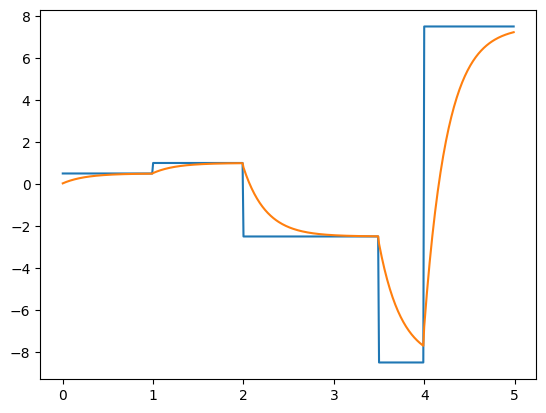

In [265]:
from control_torch import drss, set_seed, forced_response, tf2ss, c2d, perturb_matrices, perturb_parameters
batch_r_test = 5


T = 5
ts = 1e-2
t = torch.arange(0, T, ts, device=device, dtype=torch.float32).view(-1, 1)

R = torch.zeros([batch_r_test, len(t)], device=device, dtype=torch.float32)
for j in range(batch_r_test):
    r = torch.ones_like(t, device=device, dtype=torch.float32)
    r[t < 1] = np.random.choice(np.arange(-10,10,.5))
    r[(t >= 2) & (t < 3.5)] = np.random.choice(np.arange(-10,10,.5))
    r[(t >= 3.5) & (t < 4)] = np.random.choice(np.arange(-10,10,.5))
    r[(t >= 4) & (t < 5)] = np.random.choice(np.arange(-10,10,.5))
    R[j] = r.reshape(-1)

tau = 1
M_num = torch.tensor([0.01, 1], device=device, dtype=torch.float32)  # Numerator coefficients
M_den = torch.tensor([tau/4, 1], device=device, dtype=torch.float32)  # Denominator coefficients
M = tf2ss(M_num, M_den, device=device)
M_d = c2d(*M, ts, device=device)

Y_D = torch.zeros([batch_r_test, len(t)], device=device, dtype=torch.float32)
for j in range(batch_r_test):
    y_d = forced_response(*M_d, R[j].reshape(-1,1))
    Y_D[j] = y_d.reshape(-1)

plt.plot(t.cpu().numpy(), R[0].cpu().numpy())
plt.plot(t.cpu().numpy(), Y_D[0].cpu().numpy())

In [266]:
set_seed(42)
perturb_percentage = 0
seq_len = 300
nx = 2
nu = 1
ny = 1

# define settings
ts = 1e-2

# define nominal model
G_0 = drss(nx, nu, ny, device=device)

In [267]:
G = perturb_matrices(*G_0, percentage=perturb_percentage, device=device) 

In [268]:
G

(tensor([[ 0.0194,  0.2161],
         [-0.0172,  0.0849]], device='cuda:0'),
 tensor([[ 0.1391],
         [-0.1082]], device='cuda:0'),
 tensor([[-0.5187,  1.2268]], device='cuda:0'),
 tensor([[-0.]], device='cuda:0'))

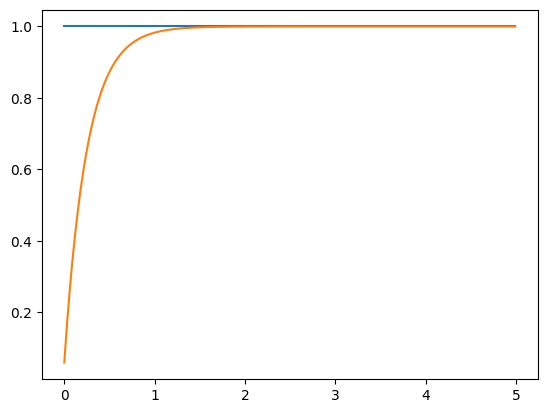

In [269]:
step = torch.ones_like(t, device=device, dtype=torch.float32)
step_response = forced_response(*M_d, step)
plt.plot(t.cpu().numpy(), step.cpu().numpy())
plt.plot(t.cpu().numpy(), step_response.cpu().numpy())

In [270]:
print(model.proportional_coefficient)
print(model.integral_coefficient)
print(model.derivative_coefficient)

Parameter containing:
tensor([1.4827], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([1.2257], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.8940], device='cuda:0', requires_grad=True)


In [279]:
H = 500 # this could need tuning
noisy = True
std_dev = 0.5
YY = torch.zeros([batch_r_test,len(t)], device=device, dtype=torch.float32)
for j in range(batch_r_test):
    print('Reference n.',j)
    E = torch.empty_like(t, device=device, dtype=torch.float32).reshape(1,-1,1)
    U = torch.empty(t.size(0)+1, device=device, dtype=torch.float32).reshape(1,-1,1)
    Y = torch.empty_like(t, device=device, dtype=torch.float32).reshape(1,-1,1)
    
    with torch.no_grad():
        # initial
        U[0,0,0] = 0
        y_i = 0
        x_i = torch.zeros(nx, device=device, dtype=torch.float32)
        
        for i in range(len(t)):
            
            if (i % 100 == 0) : print('time instant:', i)
            # start the loop with error
            e_i = R[j,i] - y_i
                
            Y[0,i,0] = y_i
            E[0,i,0] = e_i
            
            # Controller u(t) = C(e(t),u(t-1))
            if i < H:
                pred = model(E[:, :i+1, :], U[:, :i+1, :])
            else:
                pred = model(E[:, i-H+1:i+1, :], U[:, i-H+1:i+1, :])
                
            U[0,i+1,0] = pred[0,-1,0] # just for coherence, it could be directly be u_i_prev
            # Generate a single value from white noise with 0 mean and 1 std dev
            if noisy :
                white_noise_value1 = torch.randn(1).item() * std_dev 
                white_noise_value2 = torch.randn(1).item() * std_dev
                white_noise_value3 = torch.randn(1).item() * std_dev
                state_noise = torch.tensor([white_noise_value1, white_noise_value2],device = device, dtype=torch.float32)
                y, x_i = forced_response(*G, U[0,i:i+2,:], return_x=True, x0= x_i + state_noise)
                y_i = y[-1] + white_noise_value3
            else : 
                y, x_i = forced_response(*G, U[0,i:i+2,:], return_x=True, x0= x_i)
                y_i = y[-1] 
    YY[j] = Y[0,:,0]

Reference n. 0
time instant: 0
time instant: 100
time instant: 200
time instant: 300
time instant: 400
Reference n. 1
time instant: 0
time instant: 100
time instant: 200
time instant: 300
time instant: 400
Reference n. 2
time instant: 0
time instant: 100
time instant: 200
time instant: 300
time instant: 400
Reference n. 3
time instant: 0
time instant: 100
time instant: 200
time instant: 300
time instant: 400
Reference n. 4
time instant: 0
time instant: 100
time instant: 200
time instant: 300
time instant: 400


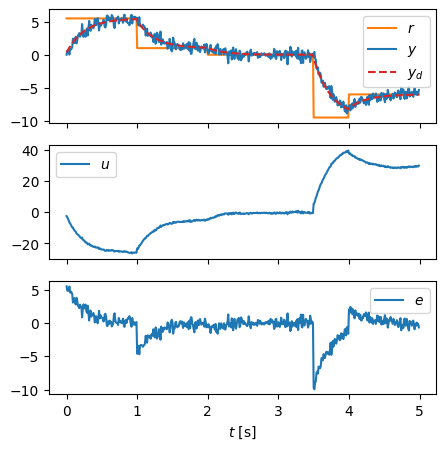

In [280]:
## THIS PLOT REFERS TO THE LAST SAMPLE
fig = plt.figure(figsize=(5, 5))
ax1 = plt.subplot(311)
#plt.plot(t_CL, r)
plt.plot(t.cpu().numpy(), R[batch_r_test-1].cpu().numpy(), label="$r$", c='tab:orange')
plt.plot(t.cpu().numpy(), YY[batch_r_test-1].cpu().numpy(), label="$y$", c='tab:blue', alpha=1)
plt.plot(t.cpu().numpy(), Y_D[batch_r_test-1].cpu().numpy(), label="$y_d$", c='tab:red', alpha=1, linestyle='--')
plt.legend(['$r$','$y$','$y_d$'])
# plt.xlim([0, 0.43])
# plt.ylim([0, 10])
plt.tick_params('x', labelbottom=False)

ax2 = plt.subplot(312, sharex=ax1)
plt.plot(t.cpu().numpy(), U[0,1:,0].cpu().numpy(), c='tab:blue', alpha=1)
# plt.plot(t_CL[:-1], batch_u[0,1:,0] * u_std, c='tab:green', alpha=1)
plt.legend(['$u$', '$u_{ideal}$'])
# plt.xlim([10, 12])
plt.tick_params('x', labelbottom=False)

ax3 = plt.subplot(313, sharex=ax1)
plt.plot(t.cpu().numpy(), E[0,:,0].cpu().numpy(), c='tab:blue', alpha=1)
# plt.plot(t_CL, batch_e[0,:,0] * e_std, c='tab:green', alpha=1)
plt.xlabel('$t$ [s]')
# plt.ylim([0, 4])
plt.legend(['$e$', '$e_{ideal}$'])

# plt.savefig('transformer_controller.pdf')

plt.show()

/tmp/ipykernel_21702/3847575754.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


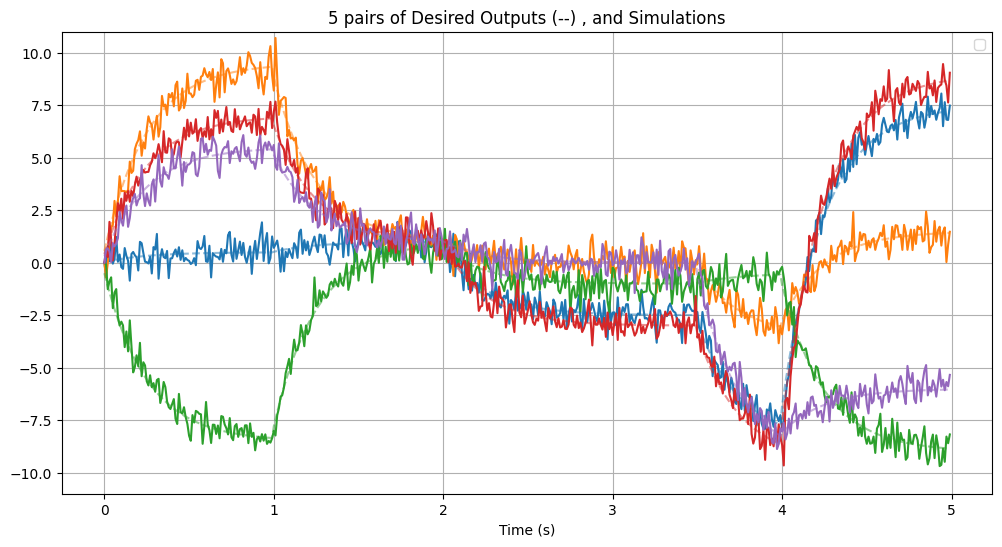

In [281]:
cmap = plt.get_cmap('tab10')  # You can use any colormap you like
colors = [cmap(i) for i in range(batch_r_test)]

plt.figure(figsize=(12, 6))

for i in range(batch_r_test):
    color = colors[i]
    plt.plot(t.cpu().numpy(), YY[i].cpu().numpy(), alpha=1, color = color)
    #plt.plot(t.cpu().numpy(), R[i].cpu().numpy(),linestyle='-.', label='Reference Signal (r)', alpha=0.5)
    plt.plot(t.cpu().numpy(), Y_D[i].cpu().numpy(), linestyle='--', color = color, alpha=0.5)

plt.xlabel('Time (s)')
plt.title('5 pairs of Desired Outputs (--) , and Simulations')
plt.ylim([-11, 11])
plt.legend()
plt.grid(True)
plt.show()

In [274]:
##MEAN SQUARED ERROR
MSE = np.zeros([batch_r_test,1])
for j in range(batch_r_test) :
    error = np.array(Y_D[j].cpu() - YY[j].cpu())
    squared_error_sum = 0
    for i in range(len(error)) :
        squared_error_sum = squared_error_sum + (error[i]*error[i])
    mse = squared_error_sum / len(error)
    print('mse of simulation n. ',j ,':',mse)
    MSE[j] = mse
total_MSE = 0
for j in range(batch_r_test) :
    total_MSE += MSE[j]
total_MSE = total_MSE / batch_r_test 
print('total MSE :', total_MSE)

mse of simulation n.  0 : 1.0047481
mse of simulation n.  1 : 0.99871933
mse of simulation n.  2 : 1.0563579
mse of simulation n.  3 : 1.0511756
mse of simulation n.  4 : 1.085057
total MSE : [1.03921158]


In [275]:
##THIS IS TO TEST SOMETHING
signal = torch.zeros((500, 1), dtype=torch.float32, device = device)
for i in range(len(y)):
    noise = torch.randn(1).item()
    signal[i] += noise
print(signal[0:45])

tensor([[-0.3001],
        [-0.7876],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000]], device='cuda:0')
